In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
import pickle

In [4]:
import imblearn


In [5]:
import datetime
from datetime import datetime
print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#df_updated = dataPreprocessing()
#simpleFeatures = ['modelType','serial_number','failure','capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw', 'smart_240_raw','smart_241_raw']

df_updated = pd.read_hdf("~/data/df_Updated.h5")
dfModels = pd.read_csv("~/data/modelList.csv")


Current Time = 20:13:31


In [6]:
df_updated['modelType1'] = df_updated['modelType']

In [7]:
df_updated = pd.merge(df_updated, dfModels[['modelType','ssd']], how = 'left',right_on = 'modelType',left_on = 'modelType1')

In [8]:
df_ssd = df_updated[df_updated['ssd']==1]

In [9]:
df_hdd = df_updated[df_updated['ssd']==0]

In [10]:
print(len(df_ssd[df_ssd.failure==1]),len(df_hdd[df_hdd.failure==1]))

1 627


In [ ]:
def dataPreprocessing(filepath, preprocessedDataPath):

    print('reading pkl')
    #dfinal = pd.read_hdf(filepathHdf)
    dfinal = pd.read_pkl(filepath)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))


    dfSorted = dfinal.sort_values(by = ['date','model'])

    dfSorted = dfinal.sort_values(by = ['date','model'])

    dfSorted['modelName']=dfSorted['model']

    dfModels = dfinal['model'].drop_duplicates().reset_index()
    dfModels['modelType'] = dfModels.index

    dfSorted = pd.merge(left = dfSorted,right = dfModels, how='left', left_on='model',right_on = 'model')

  

    models = list(dfModels['model'])

    newModelsList=[]

    #filter out Models without any failure

    def filterModels():

        for item in models:
            df_model_fail = df_fail[df_fail.model==item]
            #df_model_success = df_success[df_success.model == item]
            if len(df_model_fail)>0:
                newModelsList.append(item)


    #newModelsList = ['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640', 'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640', 'TOSHIBA MG07ACA14TA', 'HGST HUH721212ALN604', 'HGST HUH721212ALE600', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'ST6000DX000', 'ST10000NM0086', 'TOSHIBA MQ01ABF050M', 'WDC WD5000LPVX', 'ST500LM012 HN', 'HGST HUH728080ALE600', 'ST8000DM005', 'Seagate BarraCuda SSD ZA500CM10002', 'ST12000NM0117']

    print(newModelsList)


    df_updated = dfSorted[dfSorted['model'].isin(newModelsList)]

    print(df_updated.head(),len(df_updated) )




    df_updated.to_hdf(preprocessedDataPath, key='dfinal', mode='w')

    print('done ')
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))

In [ ]:
def pickleToHdfConvert(filepathPkl,filepathHdf):
    df = pd.read_pickle(filepathPkl)
    df.to_hdf(filepathHdf, key='df', mode='w')

pickleToHdfConvert("~/data/hdd_2_2018.pkl","~/data/hdd_2_2018.h5")

In [11]:
ds = df_hdd

In [12]:
dfFailures = ds[ds.failure==1]
dfSuccess = ds[ds.failure==0].sample(n = 100000)
dfsample =  pd.concat([dfSuccess, dfFailures], axis=0)

In [142]:

dstrain = dfsample[dfsample.capacity_bytes>0]


print(len(dstrain[dstrain.failure==0]),len(dstrain[dstrain.failure==1]),len(dstrain) )

#Y = dstrain[['failure']]

#X = dstrain[simpleFeatures]

99981 626 100607


In [143]:
print(len(dfSuccess))

100000


In [15]:
dstrain.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw', 'modelName', 'index', 'modelType_x', 'modelType1',
       'modelType_y', 'ssd'],
      dtype='object', length=135)

In [144]:
df1 = dfFailures[['date','model','failure']].groupby(by = ['model']).count()
dfmodelFailed = pd.DataFrame(dstrain[dstrain.failure==1].groupby(by = ['model']).count()[['modelType_x','failure']])

In [145]:
df2 = df1[df1.failure>=19]
df3 = df2.copy()
df3['model'] = df2.index

In [146]:
print(df3)

                      date  failure                 model
model                                                    
HGST HMS5C4040BLE640    19       19  HGST HMS5C4040BLE640
ST12000NM0007          365      365         ST12000NM0007
ST4000DM000             72       72           ST4000DM000
ST8000DM002             36       36           ST8000DM002
ST8000NM0055            50       50          ST8000NM0055
TOSHIBA MQ01ABF050      25       25    TOSHIBA MQ01ABF050


In [147]:
modelFailed = list(df3['model'])

In [20]:
print(modelFailed)

['HGST HMS5C4040BLE640', 'ST12000NM0007', 'ST4000DM000', 'ST8000DM002', 'ST8000NM0055', 'TOSHIBA MQ01ABF050']


In [21]:
simpleFeatures = ['capacity_bytes','modelType','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']



In [148]:
#dstrain= dstrain[dstrain.model.isin(modelFailed)]
dstrain= dstrain

In [149]:
print(len(dstrain))

100607


In [150]:
dfFailures = dstrain[dstrain.failure==1]
dfSuccess = dstrain[dstrain.failure==0]

In [151]:
import matplotlib.pyplot as plt

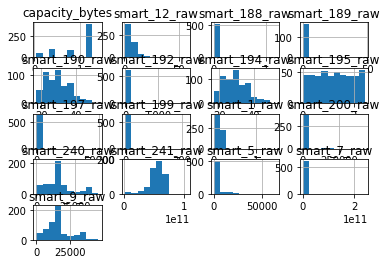

In [26]:
dfFailures[simpleFeaturesHist].hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062c271e48>,
      dtype=object)

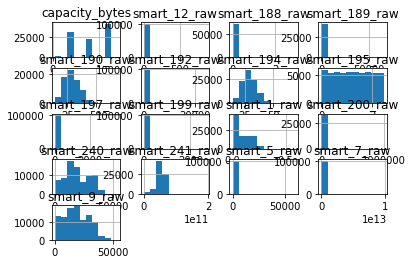

In [27]:
dfSuccess[simpleFeaturesHist].hist()

In [30]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

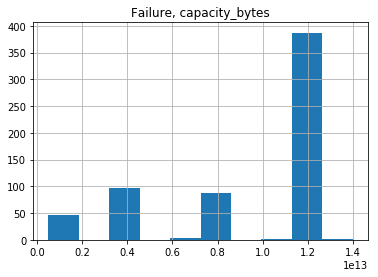

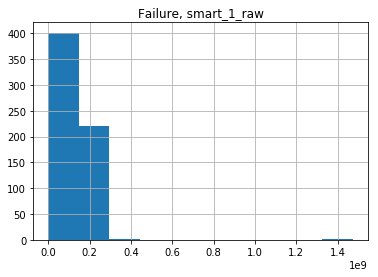

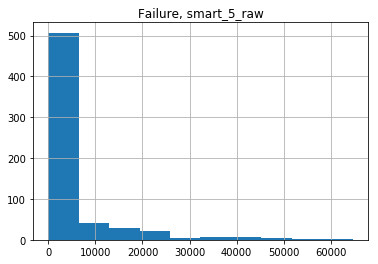

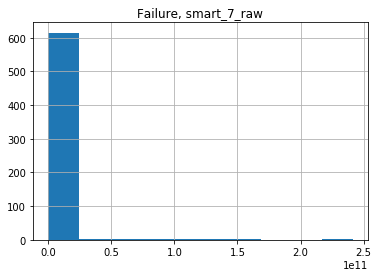

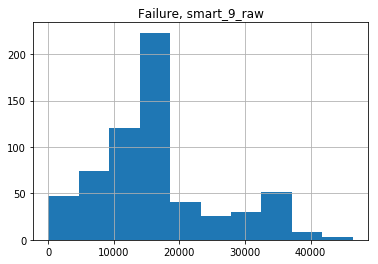

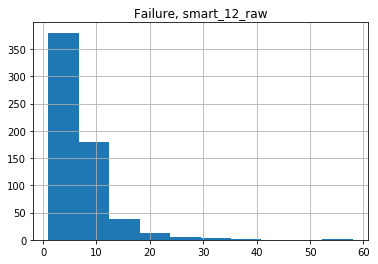

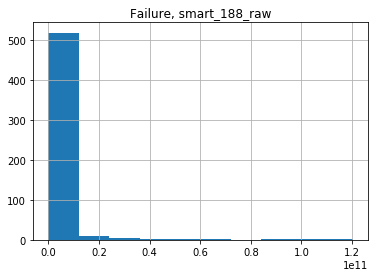

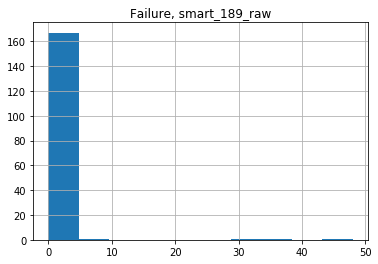

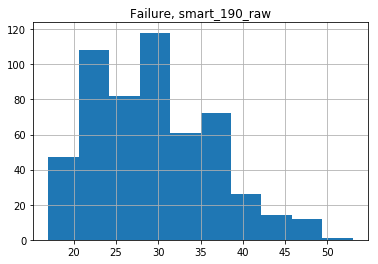

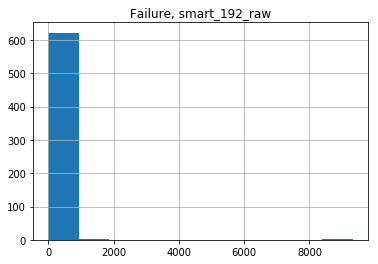

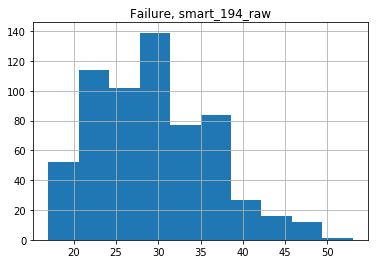

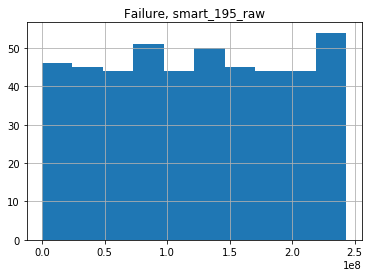

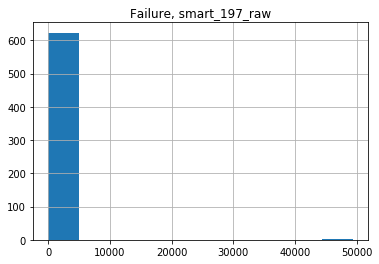

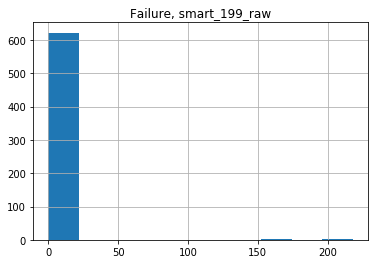

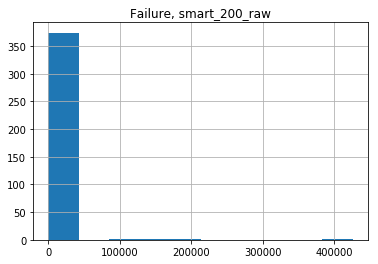

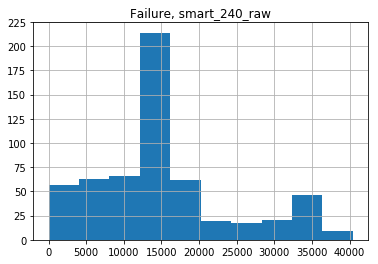

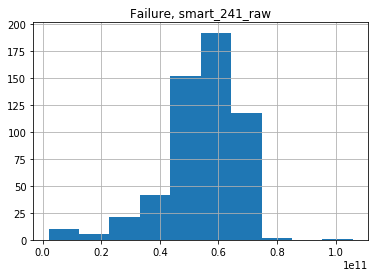

In [47]:

for item in simpleFeaturesHist:
    dfFailures[item].hist()
    plt.title('Failure, '+ str(item))

    #dfSuccess[item].hist()
    #plt.title('NON - Failure, '+ str(item))
    plt.show()
#counts, bins = np.histogram(dfFailures[['smart_194_raw']])
#plt.hist(bins[:-1], bins, weights=counts)
#plt.hist(dfFailures[['smart_194_raw']].dropna(), 50, density=True, facecolor='g', alpha=0.75)
#plt.show()

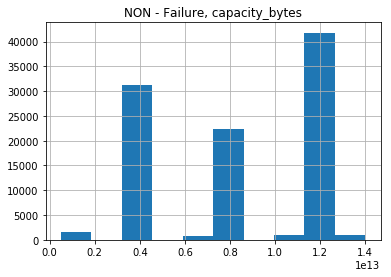

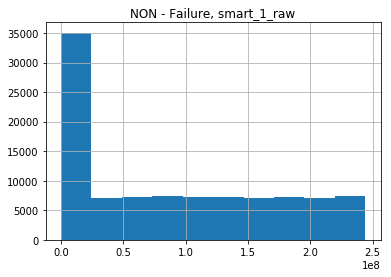

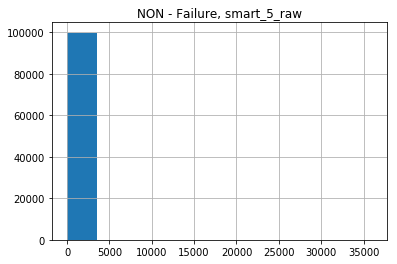

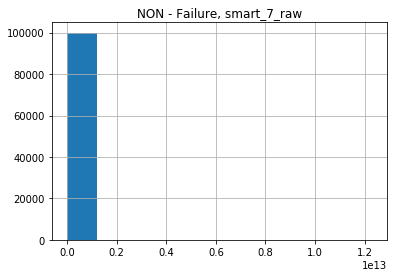

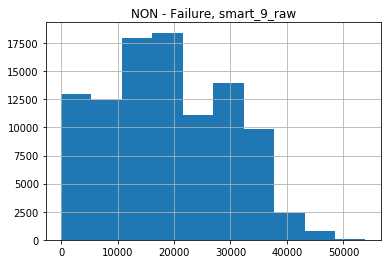

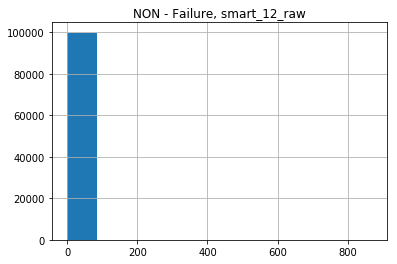

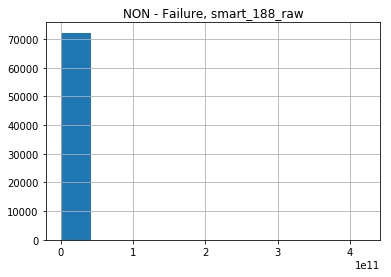

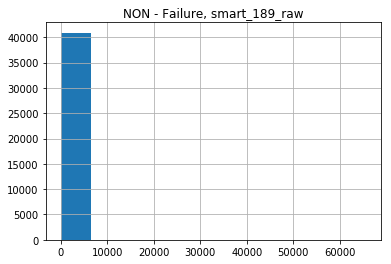

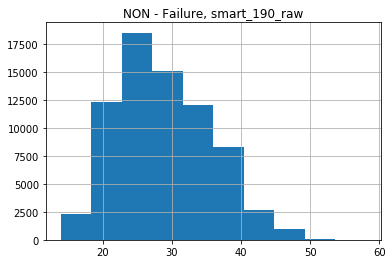

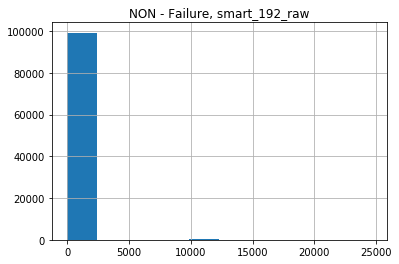

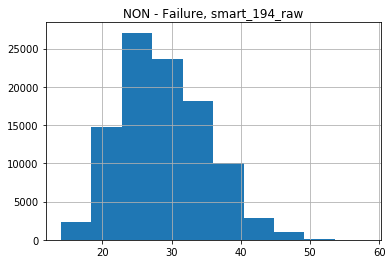

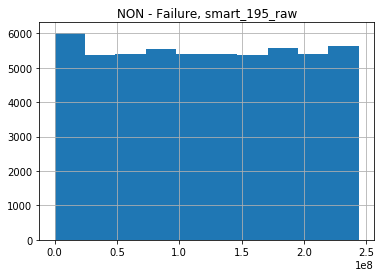

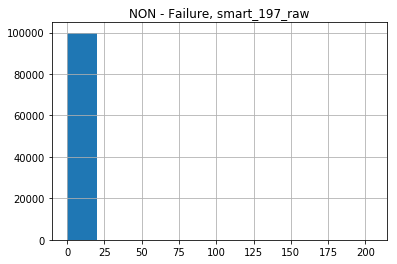

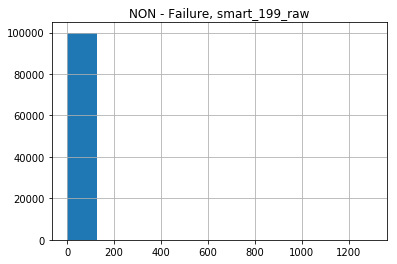

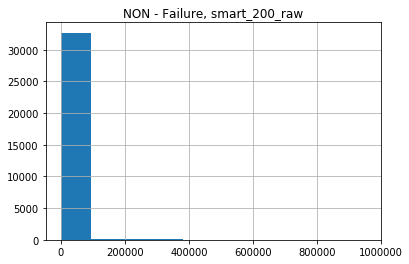

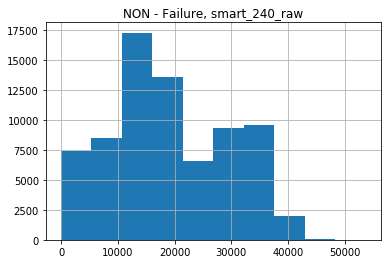

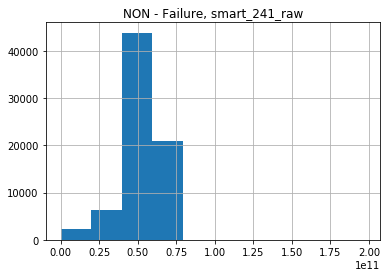

In [48]:
for item in simpleFeaturesHist:
   # dfFailures[item].hist()
    #plt.title('Failure, '+ str(item))

    dfSuccess[item].hist()
    plt.title('NON - Failure, '+ str(item))
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062b7687f0>]],
      dtype=object)

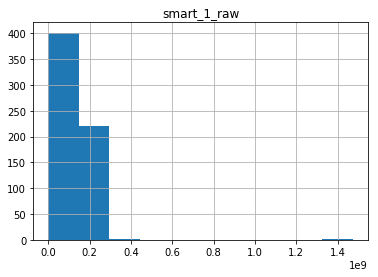

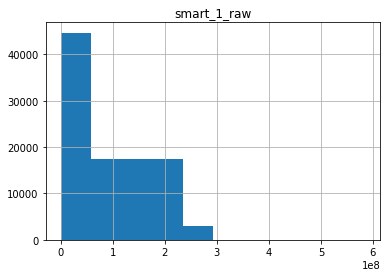

In [30]:
dfFailures[['smart_1_raw']].hist()
dfSuccess[['smart_1_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062b5c4a90>]],
      dtype=object)

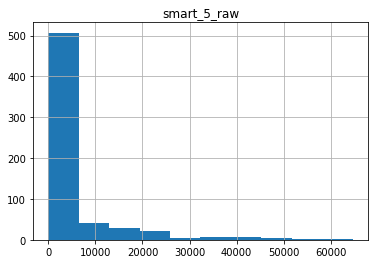

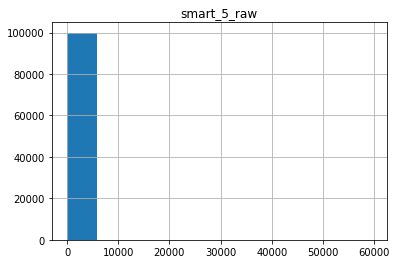

In [31]:
dfFailures[['smart_5_raw']].hist()
dfSuccess[['smart_5_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062b3e3b70>]],
      dtype=object)

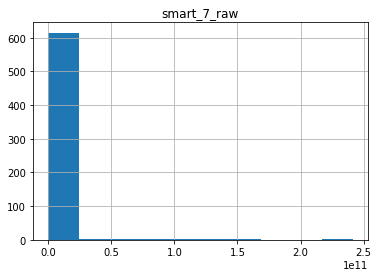

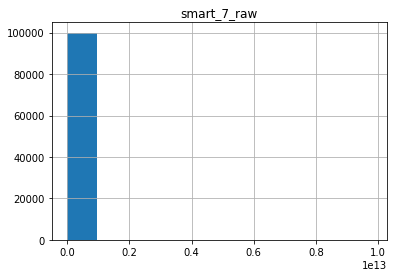

In [32]:
dfFailures[['smart_7_raw']].hist()
dfSuccess[['smart_7_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062be0d940>]],
      dtype=object)

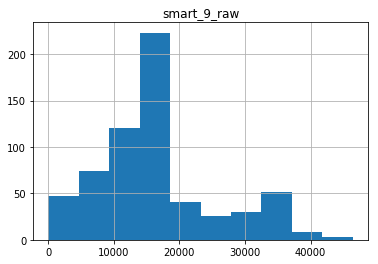

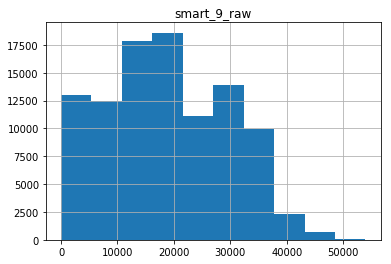

In [33]:
dfFailures[['smart_9_raw']].hist()
dfSuccess[['smart_9_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062bb378d0>]],
      dtype=object)

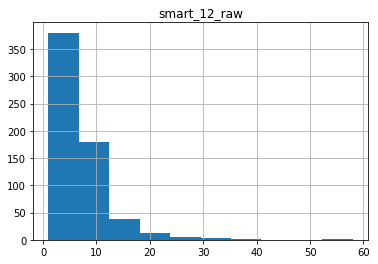

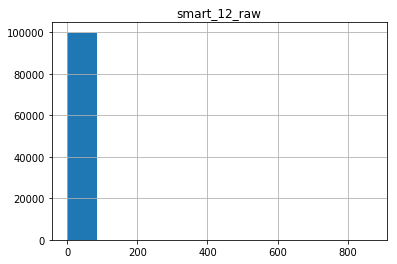

In [34]:
dfFailures[['smart_12_raw']].hist()
dfSuccess[['smart_12_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062ccd4d68>]],
      dtype=object)

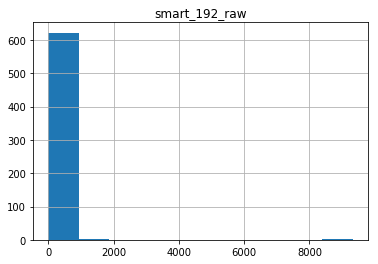

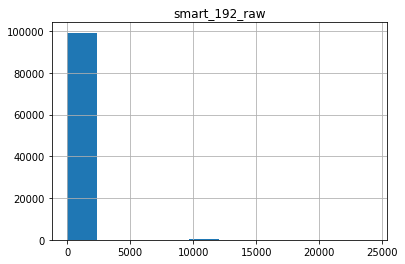

In [35]:
dfFailures[['smart_192_raw']].hist()
dfSuccess[['smart_192_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062bb37240>]],
      dtype=object)

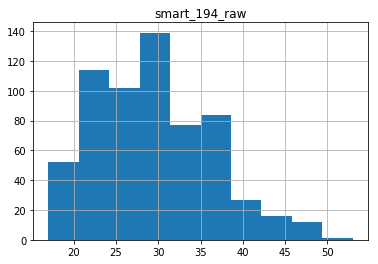

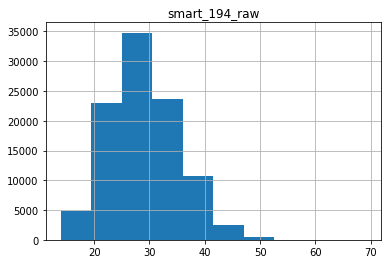

In [36]:
dfFailures[['smart_194_raw']].hist()
dfSuccess[['smart_194_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062b735c88>]],
      dtype=object)

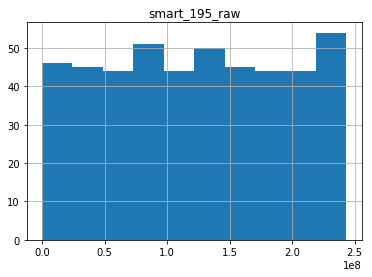

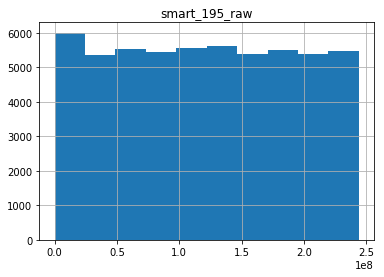

In [37]:
dfFailures[['smart_195_raw']].hist()
dfSuccess[['smart_195_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062b5fdef0>]],
      dtype=object)

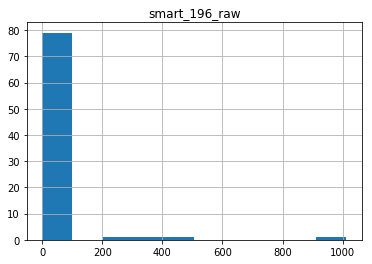

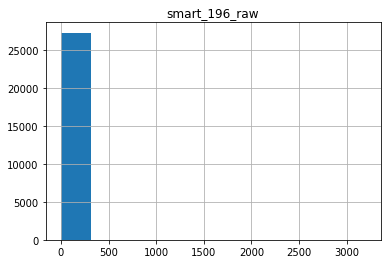

In [38]:
dfFailures[['smart_196_raw']].hist()
dfSuccess[['smart_196_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062be67cc0>]],
      dtype=object)

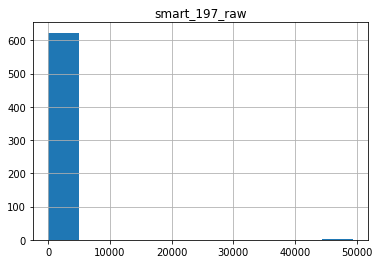

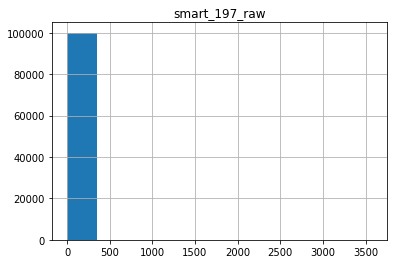

In [39]:
dfFailures[['smart_197_raw']].hist()
dfSuccess[['smart_197_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062c1c29e8>]],
      dtype=object)

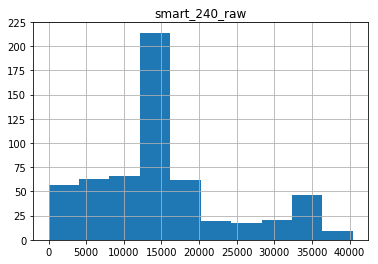

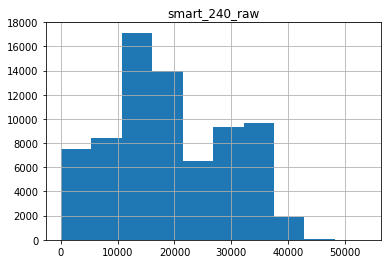

In [40]:
dfFailures[['smart_240_raw']].hist()
dfSuccess[['smart_240_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062bf16cc0>]],
      dtype=object)

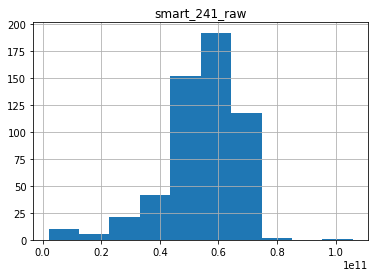

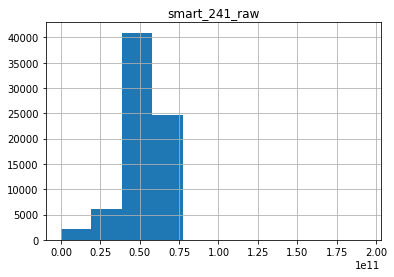

In [41]:
dfFailures[['smart_241_raw']].hist()
dfSuccess[['smart_241_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062bf9add8>]],
      dtype=object)

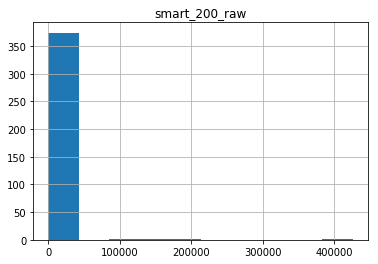

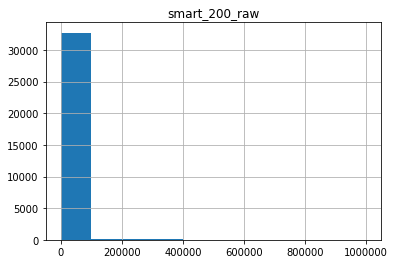

In [42]:
dfFailures[['smart_200_raw']].hist()
dfSuccess[['smart_200_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062c0e15c0>]],
      dtype=object)

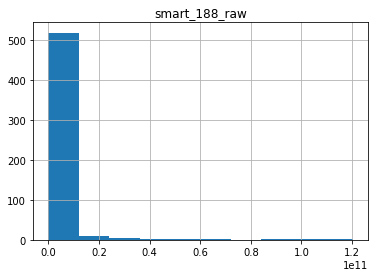

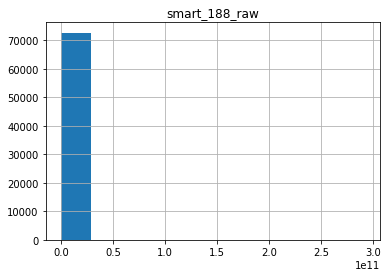

In [43]:
dfFailures[['smart_188_raw']].hist()
dfSuccess[['smart_188_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062bd175f8>]],
      dtype=object)

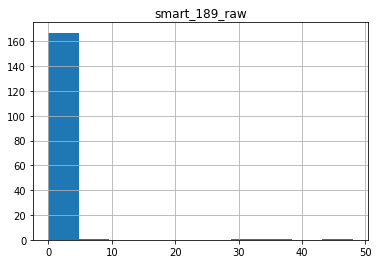

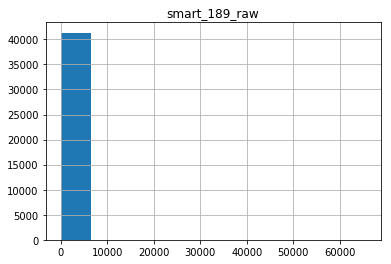

In [44]:
dfFailures[['smart_189_raw']].hist()
dfSuccess[['smart_189_raw']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f062c1657b8>]],
      dtype=object)

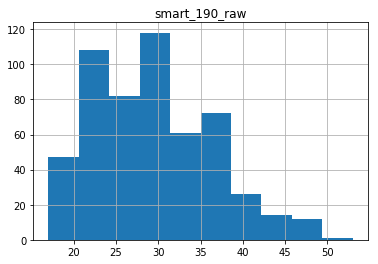

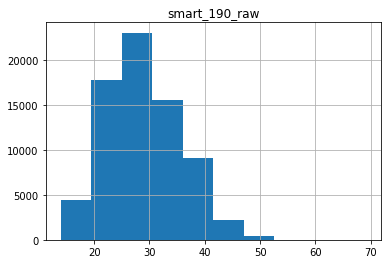

In [45]:
dfFailures[['smart_190_raw']].hist()
dfSuccess[['smart_190_raw']].hist()

In [152]:
dstrain['modelType']=dstrain['modelType_x']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
Y = dstrain[['failure']]

X = dstrain[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)




print('Handling imbalanced data - starting SMOTE ...')


def overSamplingWithSMOTE(X_train,y_train0):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    #convert pandas to array
    y_train = np.array(y_train0.failure)

    #Create final training dataset
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    return X_train_res, y_train_res


X_train_res, y_train_res = overSamplingWithSMOTE(X_train,y_train0)

Number transactions X_train dataset:  (100607, 18)
Number transactions y_train dataset:  (100607, 1)
Current Time = 18:46:08
Handling imbalanced data - starting SMOTE ...


In [54]:
import seaborn


In [55]:
def readingTestDataset(filepath, dfModels, features, models):
    dsTest0 = pd.read_hdf(filepath)
    dsTest = dsTest0[dsTest0.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    #dsTest = dsTest[dsTest.model.isin(models)]
    # validate for another quarter
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest

In [56]:
%time    Xtest,Ytest = readingTestDataset("~/data/hdd_4_2016.h5",dfModels, simpleFeatures,modelFailed)


CPU times: user 39.1 s, sys: 23.4 s, total: 1min 2s
Wall time: 35.2 s


In [154]:
print(len(y_train_res))
y_res =  pd.DataFrame(y_train_res).rename(columns = {0:'fail'})
print(len(y_res), len(y_res[y_res.fail==1]),len(y_res[y_res.fail==0]) ,len(y_res[y_res.fail==1])/len(y_res[y_res.fail==0]) )

199962
199962 99981 99981 1.0


In [185]:
def logisticRegression(X_train_res, y_train_res, Xtest, Ytest):
#   clf2 = LogisticRegression(penalty = 'l2', solver = 'saga',tol = 1e-6).fit(X_train_res, y_train_res)
    clf2 = LogisticRegression(C=0.05).fit(X_train_res, y_train_res)

    #(penalty = 'l1', solver = 'liblinear',tol = 1e-6, max_iter = int(1e6),warm_start = True,intercept_scaling = 10000.)

    #predictions2 = clf2.predict(Xtest)

    filename = 'finalized_model.sav'
    pickle.dump(clf2, open(filename, 'wb'))
    return clf2

In [186]:
clf2 = logisticRegression(X_train_res, y_train_res, Xtest, Ytest)

(0, 1)

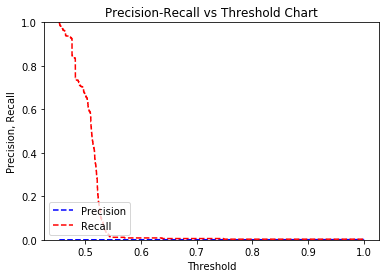

In [187]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)
#pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

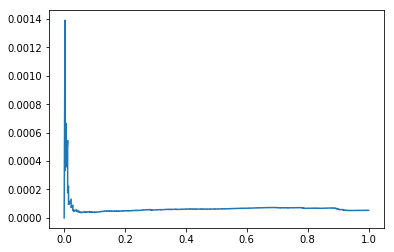

In [188]:
plt.plot( recall[: -1], precision[: -1], label="Precision v recall")

In [159]:
print(len(precision))

4238972


In [189]:
predictions3 = clf2.predict(Xtest)
predictions3_prob = clf2.predict_proba(Xtest)[:,1]
print('results after over sampling, logistic regressioin, no device filtering')

print(classification_report(Ytest, predictions3))
print(confusion_matrix(Ytest, predictions3))




results after over sampling, logistic regressioin, no device filtering
              precision    recall  f1-score   support

           0       1.00      0.51      0.68   6589098
           1       0.00      0.67      0.00       350

    accuracy                           0.51   6589448
   macro avg       0.50      0.59      0.34   6589448
weighted avg       1.00      0.51      0.68   6589448

[[3372618 3216480]
 [    117     233]]


In [170]:
#plt.plot( predictions3, predictions3_prob, label="Precision v probability")
predProb3 = round(pd.DataFrame(predictions3_prob),5).rename(columns = {0: 'probability'})
pred3 = pd.DataFrame(predictions3).rename(columns = {0: 'prediction'})
predLog = pd.merge(pred3,predProb3, how = 'left', right_index = True, left_index=True)

In [162]:
predLog.to_csv("~/data/prediction_LogReg1.csv")

In [171]:
yscore = clf2.decision_function(Xtest)


In [172]:
print(yscore)

[-0.07067255 -0.07067255 -0.09422998 ... -0.07067255  0.12156823
  0.03718033]


In [173]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(Ytest, yscore, pos_label=0)


Text(0.5, 1.0, 'ROC, non-failures, 0.43')

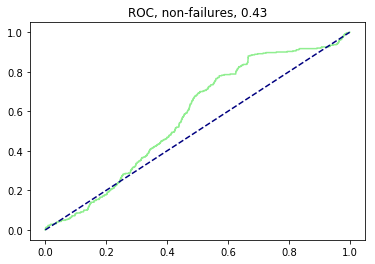

In [174]:
plt.plot(tpr,fpr,color='lightgreen')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC, non-failures, "+ str(round(auc(fpr, tpr),2)))

In [175]:
print(thresholds)

[116.37747938 115.37747938  22.77967937 ...  -0.1884597   -0.1884597
  -0.30620355]


In [176]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = metrics.roc_curve(Ytest, yscore, pos_label=1)




Text(0.5, 1.0, 'ROC, failures, 0.57')

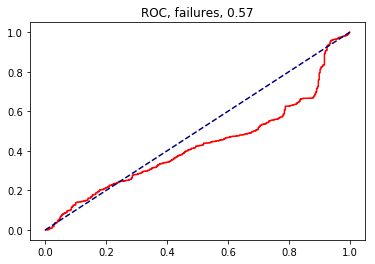

In [177]:
plt.plot(tpr1,fpr1,color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC, failures, "+ str(round(auc(fpr1, tpr1),2)))

In [184]:
print(tpr1)

[0. 0. 0. ... 1. 1. 1.]


In [71]:
def randomForest(X_train_res, y_train_res):
    #Random forests
    print('starting random forest')
    clfRF = RandomForestClassifier(max_depth=4, random_state=0,max_samples=1000, class_weight = 'balanced').fit(X_train_res, y_train_res)
    print('feature impoartance for RF')
    print(clfRF.feature_importances_)
    pd.DataFrame(clfRF.feature_importances_).to_csv("~/data/featuresSelection.csv")
    return clfRF

In [55]:
clfRF = randomForest(X_train_res, y_train_res)
predictionRF = clfRF.predict(Xtest)
print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[0.03311038 0.02751603 0.02313447 0.42273776 0.01048662 0.0292754
 0.0174495  0.0300028  0.00112327 0.01159815 0.02032245 0.00409581
 0.02311568 0.30343708 0.00057039 0.00184776 0.0275699  0.01260656]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   6589098
           1       0.00      0.54      0.01       350

    accuracy                           0.99   6589448
   macro avg       0.50      0.76      0.50   6589448
weighted avg       1.00      0.99      1.00   6589448

[[6528909   60189]
 [    162     188]]


In [72]:
#dfsampleSuccess = dfSuccess.sample(n = 100000-len(dfFailures))
dfsampleSuccess = dfSuccess
  
dfsampleFailure = dfFailures


In [73]:
dfBatch = pd.concat([dfsampleSuccess, dfsampleFailure], axis=0)
dfBatch['modelType'] = dfBatch['modelType_x']
dfBatch = dstrain

In [74]:
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType_x', 'modelType1', 'modelType_y', 'ssd',
       'modelType'],
      dtype='object', length=136)

In [75]:
dfsampleSuccess = dfBatch[dfBatch.failure == 0]
  
dfsampleFailure = dfBatch[dfBatch.failure == 1]

In [76]:
Y = dfBatch[['failure']]

X = dfBatch[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)



Number transactions X_train dataset:  (100604, 18)
Number transactions y_train dataset:  (100604, 1)
Current Time = 17:35:41


In [77]:
def batchSample(dfsampleSuccess,dfsampleFailure,features):

    dfSuccessbatch = dfsampleSuccess.sample(n =100)
    dfFailurebatch = dfsampleFailure.sample(n = 100)


    dfBatch = pd.concat([dfSuccessbatch, dfFailurebatch], axis=0)

    #print(dfBatch[['failure']])


    X_batch = dfBatch[features].fillna(0)
    y_batch = dfBatch['failure']


    return X_batch,y_batch




In [80]:
def SDG(dfsampleSuccess,dfsampleFailure,features,iter):
    print(features)
    SDGmodel = linear_model.SGDClassifier(max_iter=5, tol=1e-12, loss='log',penalty='elasticnet')
    for i in range(0, iter):
        x_batch, y_batch=batchSample(dfsampleSuccess,dfsampleFailure,features)
            #print(y_batch)
        clf = SDGmodel.partial_fit(x_batch, y_batch,classes=np.unique(y_batch))
    return clf

In [78]:
#Xtest.columns
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType_x', 'modelType1', 'modelType_y', 'ssd',
       'modelType'],
      dtype='object', length=136)

In [81]:
print('Starting SGD...')
print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']



clf = SDG(dfsampleSuccess,dfsampleFailure,simpleFeatures,200)


prediction = clf.predict(Xtest)
print(confusion_matrix(Ytest,prediction))
print(classification_report(Ytest, prediction, zero_division=1))

Starting SGD...
Current Time = 17:36:14
['capacity_bytes', 'modelType', 'smart_1_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw', 'smart_194_raw', 'smart_195_raw', 'smart_197_raw', 'smart_199_raw', 'smart_200_raw', 'smart_240_raw', 'smart_241_raw']
[[      0 6589098]
 [      0     350]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00   6589098
           1       0.00      1.00      0.00       350

    accuracy                           0.00   6589448
   macro avg       0.50      0.50      0.00   6589448
weighted avg       1.00      0.00      0.00   6589448



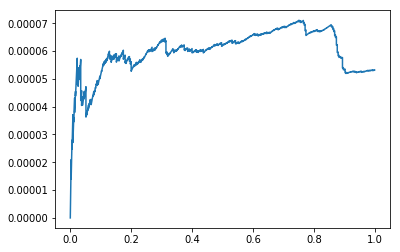

In [103]:
plt.plot( recall[: -1], precision[: -1], label="Precision v recall")

In [88]:
df_standardized = (dfsampleFailure[simpleFeaturesHist] - dfsampleFailure[simpleFeaturesHist].mean()) / dfsampleFailure[simpleFeaturesHist].std()  

,capacity_bytes,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_192_raw,smart_194_raw,smart_195_raw,smart_197_raw,smart_199_raw,smart_200_raw,smart_240_raw,smart_241_raw
27120,0.179703,-0.196818,-0.408068,-0.116200,-0.088101,-0.141383,-0.195458,0.429700,-0.483753,0.111217,-0.500295,-0.428175,-0.061568,-0.063705,-0.112688,0.047229,0.277662
32095,0.694677,0.088270,-0.073859,-0.156928,-0.895371,-0.983205,-0.195458,NaN,0.965362,-0.053958,0.986295,-0.045952,-0.065579,-0.063705,-0.112688,-0.738917,-0.522994
33109,0.694677,0.998264,-0.281776,-0.128264,-0.317203,-0.646476,-0.195458,NaN,0.675539,0.227357,0.688977,1.174094,-0.065579,-0.063705,-0.112688,-0.230699,0.136271
34690,0.694677,0.795201,-0.442259,-0.122514,-0.316762,-0.814840,-0.195458,NaN,0.530628,0.106056,0.540318,0.901844,-0.065579,-0.063705,-0.112688,-0.230591,0.166514
65340,-1.365764,-0.775340,-0.442259,-0.111566,1.869870,2.215718,-0.195458,-0.147358,-0.483753,-0.358502,-0.500295,NaN,-0.017453,-0.063705,NaN,1.955482,-0.062614
92750,-0.335260,0.705043,-0.442161,0.038672,-0.815616,-0.646476,-0.195458,-0.147358,-1.063398,-0.361082,-1.094931,0.780967,-0.065579,-0.063705,NaN,-0.654575,-1.938621
94849,-0.335260,0.174655,-0.423286,0.103875,-0.048555,-0.309747,-0.195458,-0.147358,0.240805,-0.340435,0.243000,0.069866,-0.017453,-0.063705,NaN,0.094652,-0.498020
95375,-0.335260,1.072169,-0.442259,-0.154522,-1.698001,0.195346,-0.195458,-0.147358,2.559389,-0.314627,2.621544,1.273180,-0.065579,-0.063705,NaN,-1.525388,0.345072
155465,0.694677,0.705018,0.877974,-0.142945,-0.627275,-0.141383,-0.195458,NaN,1.834831,-0.010084,1.878249,0.780933,-0.065579,-0.063705,-0.112688,-0.480802,-0.398413
157883,0.694677,0.479729,0.797337,-0.122768,-0.223088,-0.814840,-0.195458,NaN,1.255185,0.309945,1.283613,0.478884,-0.065579,-0.063705,-0.112688,-0.091139,0.810588


In [88]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [95]:
def runSVM(X_train_res, y_train_res):
    clf = svm.SVC().fit(X_train_res, y_train_res)
    return clf

In [ ]:
clf = runSVM(X_train_res, y_train_res)
prediction = clf.predict(Xtest)
print(confusion_matrix(Ytest,prediction))
print(classification_report(Ytest, prediction, zero_division=1))

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [17]:
def regressionUnderSampling(X, y):
    print('calculate under-sampling')

    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)

    print('Results with under-sampling')
    return X_resampled, y_resampled